# **Tugas Dicoding Proyek Akhir : Time Series dengan LSTM**

Nama : Moh Channa Beck Sutansyah

No Telepon : +6285728188067

Kota Tempat Tinggal : Kudus


**1.Download Dataset dari Kaggle**

In [ ]:
#Install Kaggle
!pip install -q kaggle

In [ ]:
#Upload Json Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohchannabeck","key":"5d211cbe07a6144bdf25273703ebce86"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
#Download Dataset dari Kaggle
!kaggle datasets download -d team-ai/bitcoin-price-prediction

  0% 0.00/37.6k [00:00<?, ?B/s]
100% 37.6k/37.6k [00:00<00:00, 14.3MB/s]


**2. Unzip File**

In [ ]:
#Unzip File
!mkdir bitcoin-price-prediction
!unzip bitcoin-price-prediction.zip -d bitcoin-price-prediction
!ls bitcoin-price-prediction

Archive:  bitcoin-price-prediction.zip
  inflating: bitcoin-price-prediction/bitcoin_price_1week_Test - Test.csv  
  inflating: bitcoin-price-prediction/bitcoin_price_Training - Training.csv  
'bitcoin_price_1week_Test - Test.csv'  'bitcoin_price_Training - Training.csv'


**3. Import Library**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



**4. Read Dataset**

In [ ]:
df = pd.read_csv('bitcoin-price-prediction/bitcoin_price_Training - Training.csv')

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
...,...,...,...,...,...,...,...
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"


In [ ]:
df['Date'] = pd.to_datetime(df.Date)
df = df.sort_values(by=['Date'])

**Mengecek Date(Timestamp) apakah memiliki data harian non-holiday lengkap?**

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2013-04-28', end='2017-07-31')
df_h = pd.DataFrame()
df_h['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_h['Holiday'] = df_h['Date'].isin(holidays)
df_h

,Date,Holiday
0,2013-04-28,False
1,2013-04-29,False
2,2013-04-30,False
3,2013-05-01,False
4,2013-05-02,False
...,...,...
1551,2017-07-27,False
1552,2017-07-28,False
1553,2017-07-29,False
1554,2017-07-30,False


Disini terlihat bahwa jumlah baris yang pada dataset bitcoin (dataset yang dipakai) sama dengan jumlah hari (non-holiday+holiday) kalendar yaitu 1556 baris.

Perlu diketahui juga bitcoin tidak memiliki hari libur trading, jadi data ini sudah lengkap dan ordered

**5. Cek Null, Set Index dan Drop Column yang tidak perlu**

In [ ]:
df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

Disini Dataset tidak memiliki missing value 

In [ ]:
df = df.set_index('Date')

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [ ]:
df = df.drop(['Open'], axis = 1)
df = df.drop(['High'], axis = 1)
df = df.drop(['Volume'], axis = 1)
df = df.drop(['Low'], axis = 1)
df = df.drop(['Market Cap'], axis = 1)

In [ ]:
df

,Close
Date,
2013-04-28,134.21
2013-04-29,144.54
2013-04-30,139.00
2013-05-01,116.99
2013-05-02,105.21
...,...
2017-07-27,2671.78
2017-07-28,2809.01
2017-07-29,2726.45


**Membagi Train dan Validation Data (80% : 20%)**

In [ ]:
test_size = 0.20
data_train, data_val = train_test_split(df.values, test_size=test_size, shuffle=False)

In [ ]:
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train.reshape(-1, 1))
data_val = scaler.fit_transform(data_val.reshape(-1, 1))

In [ ]:
split=int((1-test_size)*len(df))

date_train = df.index[:split]
date_test = df.index[split:]

In [ ]:
look_back = 20
data_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=20)     
data_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(data_val, data_val, length=look_back, batch_size=1)

Menggunakan Model Sequential + LSTM

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 60)            14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 46,071
Trainable params: 46,071
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit_generator(data_train, validation_data=(data_val), epochs=100, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
62/62 - 7s - loss: 0.0522 - mae: 0.2708 - val_loss: 0.0772 - val_mae: 0.2768
Epoch 2/100
62/62 - 2s - loss: 0.0403 - mae: 0.2314 - val_loss: 0.0665 - val_mae: 0.2474
Epoch 3/100
62/62 - 2s - loss: 0.0326 - mae: 0.2023 - val_loss: 0.0578 - val_mae: 0.2283
Epoch 4/100
62/62 - 2s - loss: 0.0269 - mae: 0.1801 - val_loss: 0.0523 - val_mae: 0.2163
Epoch 5/100
62/62 - 2s - loss: 0.0229 - mae: 0.1613 - val_loss: 0.0480 - val_mae: 0.2088
Epoch 6/100
62/62 - 2s - loss: 0.0201 - mae: 0.1512 - val_loss: 0.0447 - val_mae: 0.2045
Epoch 7/100
62/62 - 2s - loss: 0.0180 - mae: 0.1448 - val_loss: 0.0424 - val_mae: 0.2026
Epoch 8/100
62/62 - 2s - loss: 0.0165 - mae: 0.1404 - val_loss: 0.0403 - val_mae: 0.2013
Epoch 9/100
62/62 - 2s - loss: 0.0153 - mae: 0.1360 - val_loss: 0.0388 - val_mae: 0.1997
Epoch 10/100
62/62 - 2s - loss: 0.0144 - mae: 0.1325 - val_loss: 0.0375 - val_mae: 0.1987
Epoch 11/100
62/62 - 2s - loss: 0.0138 - mae: 0.1301 - val_loss: 0.0364 - val_mae: 0.1987
Epoch 12/100
62/62 

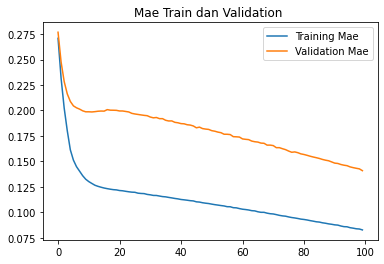

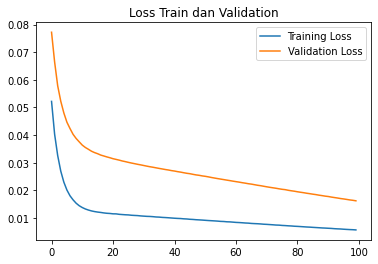

In [ ]:
#Memvisualisasikan Akurasi dan Loss dari tiap-tiap Epochs
train_mae = history.history['mae']
val_mae = history.history['val_mae']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)
plt.plot(epochs_range, train_mae, label='Training Mae')
plt.plot(epochs_range, val_mae, label='Validation Mae')
plt.title('Mae Train dan Validation ')
plt.legend()
plt.show()

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Train dan Validation')
plt.legend()
plt.show()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit_generator(data_train, validation_data=(data_val), epochs=100, verbose=2,callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
62/62 - 7s - loss: 0.0052 - mae: 0.0793 - val_loss: 0.0151 - val_mae: 0.1355
Epoch 2/100
62/62 - 2s - loss: 0.0052 - mae: 0.0788 - val_loss: 0.0150 - val_mae: 0.1345
Epoch 3/100
62/62 - 2s - loss: 0.0051 - mae: 0.0780 - val_loss: 0.0148 - val_mae: 0.1335
Epoch 4/100
62/62 - 2s - loss: 0.0050 - mae: 0.0774 - val_loss: 0.0146 - val_mae: 0.1331
Epoch 5/100
62/62 - 2s - loss: 0.0050 - mae: 0.0770 - val_loss: 0.0145 - val_mae: 0.1327
Epoch 6/100
62/62 - 2s - loss: 0.0049 - mae: 0.0765 - val_loss: 0.0143 - val_mae: 0.1311
Epoch 7/100
62/62 - 2s - loss: 0.0049 - mae: 0.0758 - val_loss: 0.0142 - val_mae: 0.1304
Epoch 8/100
62/62 - 2s - loss: 0.0048 - mae: 0.0755 - val_loss: 0.0140 - val_mae: 0.1297
Epoch 9/100
62/62 - 2s - loss: 0.0047 - mae: 0.0749 - val_loss: 0.0139 - val_mae: 0.1287
Epoch 10/100
62/62 - 2s - loss: 0.0047 - mae: 0.0744 - val_loss: 0.0137 - val_mae: 0.1286
Epoch 11/100
62/62 - 2s - loss: 0.0046 - mae: 0.0737 - val_loss: 0.0136 - val_mae: 0.1273
Epoch 12/100
62/62 

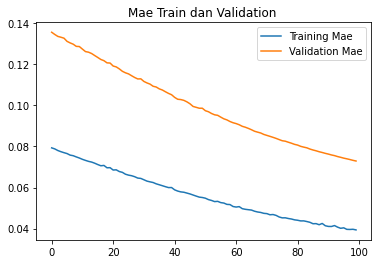

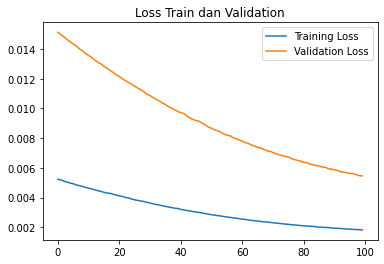

In [ ]:
#Memvisualisasikan Akurasi dan Loss dari tiap-tiap Epochs
train_mae = history.history['mae']
val_mae = history.history['val_mae']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)
plt.plot(epochs_range, train_mae, label='Training Mae')
plt.plot(epochs_range, val_mae, label='Validation Mae')
plt.title('Mae Train dan Validation ')
plt.legend()
plt.show()

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Train dan Validation')
plt.legend()
plt.show()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit_generator(data_train, validation_data=(data_val), epochs=100, verbose=2,callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
62/62 - 7s - loss: 0.0018 - mae: 0.0389 - val_loss: 0.0054 - val_mae: 0.0726
Epoch 2/100
62/62 - 2s - loss: 0.0018 - mae: 0.0387 - val_loss: 0.0054 - val_mae: 0.0723
Epoch 3/100
62/62 - 2s - loss: 0.0018 - mae: 0.0388 - val_loss: 0.0053 - val_mae: 0.0719
Epoch 4/100
62/62 - 2s - loss: 0.0018 - mae: 0.0387 - val_loss: 0.0053 - val_mae: 0.0716
Epoch 5/100
62/62 - 2s - loss: 0.0018 - mae: 0.0384 - val_loss: 0.0053 - val_mae: 0.0712
Epoch 6/100
62/62 - 2s - loss: 0.0018 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0711
Epoch 7/100
62/62 - 2s - loss: 0.0017 - mae: 0.0378 - val_loss: 0.0052 - val_mae: 0.0706
Epoch 8/100
62/62 - 2s - loss: 0.0017 - mae: 0.0377 - val_loss: 0.0052 - val_mae: 0.0703
Epoch 9/100
62/62 - 2s - loss: 0.0017 - mae: 0.0372 - val_loss: 0.0051 - val_mae: 0.0700
Epoch 10/100
62/62 - 2s - loss: 0.0017 - mae: 0.0373 - val_loss: 0.0050 - val_mae: 0.0697
Epoch 11/100
62/62 - 2s - loss: 0.0017 - mae: 0.0373 - val_loss: 0.0050 - val_mae: 0.0694
Epoch 12/100
62/62 

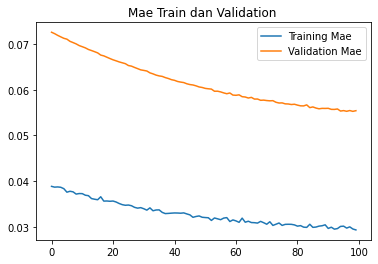

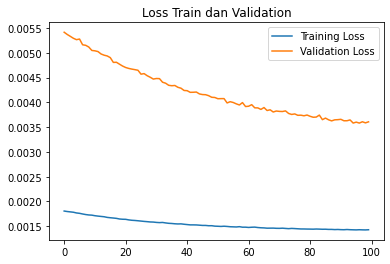

In [ ]:
#Memvisualisasikan Akurasi dan Loss dari tiap-tiap Epochs
train_mae = history.history['mae']
val_mae = history.history['val_mae']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)
plt.plot(epochs_range, train_mae, label='Training Mae')
plt.plot(epochs_range, val_mae, label='Validation Mae')
plt.title('Mae Train dan Validation ')
plt.legend()
plt.show()

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Train dan Validation')
plt.legend()
plt.show()

**Summary Checklist**

1.Dataset memiliki minimal memiliki 1000 sampel

In [ ]:
df.count()

Close    1556
dtype: int64

2. Harus menggunakan LSTM dalam arsitektur model


In [ ]:
#model = tf.keras.models.Sequential([
  #tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(look_back, 1)),
  #tf.keras.layers.LSTM(60),
  #tf.keras.layers.Dense(30, activation="relu"),
  #tf.keras.layers.Dense(10, activation="relu"),
  #tf.keras.layers.Dense(1),
#])

3. Validation set sebesar 20% dari total dataset 

In [ ]:
print('jumlah data train: ' +str(len(data_train)))
print('jumlah data validation: ' +str(len(data_val)))
print('rasio data validation: ' +str(len(data_val)/len(df)))


jumlah data train: 1244
jumlah data validation: 312
rasio data validation: 0.20051413881748073


4. Model harus menggunakan model sequential. 

In [ ]:
#model = tf.keras.models.Sequential([
  #tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(look_back, 1)),
  #tf.keras.layers.LSTM(60),
  #tf.keras.layers.Dense(30, activation="relu"),
  #tf.keras.layers.Dense(10, activation="relu"),
  #tf.keras.layers.Dense(1),
#]

5. Harus menggunakan Learning Rate pada Optimizer. 

In [ ]:
#optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

6.MAE < 10% skala data.

In [ ]:
print('Mae Train Terakhir: '+ str(history.history['mae'][99]))
print('Mae Validation Terakhir: '+ str(history.history['val_mae'][99]))

Mae Train Terakhir: 0.029356008395552635
Mae Validation Terakhir: 0.0554179809987545


In [ ]:
df.describe()

,Close
count,1556.000000
mean,584.239396
std,525.904442
min,68.430000
25%,254.320000
50%,438.855000
75%,663.402500
max,2958.110000


In [ ]:
mae = float(history.history['mae'][99])
mae_val = float(history.history['val_mae'][99])
mae_scale = round((df['Close'].max() - df['Close'].min()) * (10 / 100), 2)
if mae < mae_scale:
  print('mae train lebih kecil dari mae_scale 10% (terpenuhi)')
else:
  print('mae train lebih besar dari mae_scale(tidak terpenuhi)')
if mae_val < mae_scale:
  print('mae validation lebih kecil dari mae_scale 10% (terpenuhi)')
else:
  print('mae train lebih besar dari mae_scale(tidak terpenuhi)')

mae train lebih kecil dari mae_scale 10% (terpenuhi)
mae validation lebih kecil dari mae_scale 10% (terpenuhi)
